# Replicating Figures from Paper

We attempted to replicate the following figure from the MaMI paper using the laplacian spectral kernel we constructed.

![MaMI Figure](./mami_figure.png)

In [14]:
### import modules
from graspologic.plot import heatmap
import numpy as np
import random
import pandas as pd

In [242]:
### load data
from pathlib import Path

graphs_all = np.zeros((225, 200, 200))
species_list = []

npy_files = Path('../mami_data/conn').glob('*')
for i, file in enumerate(npy_files):
    graphs_all[i] = np.load(file)
    filestr = str(file).split('/')[-1]
    filestr = filestr.split('.')[0]
    species_list.append(filestr)

random.seed(3)

# construct labels based on taxonomy orders
info_df = pd.read_csv('../mami_data/info.csv')
filenames = info_df.pop("Filename").to_list()
orders_all = info_df.pop("Order").to_list()
#print(orders_all)

order_mapper = {}
for i, filename in enumerate(filenames):
    if orders_all[i] == 'Artiodactyla':
        orders_all[i] = 'Cetartiodactyla'
    order_mapper[filename] = orders_all[i]

labels_all = list(map(order_mapper.get, species_list))

# get subset of labels, graphs
#orders = ['Chiroptera', 'Primates']
orders = ['Chiroptera', 'Rodentia', 'Cetartiodactyla', 'Carnivora', 'Perissodactyla', 'Primates']
#ind_ch = []
#ind_pr = []
ind = []
labels = []

for i, label in enumerate(labels_all):
    if label in orders:
        labels.append(label)
        ind.append(i)
    #if label == 'Chiroptera':
        #labels.append(label)
        #ind_ch.append(i)
    #elif label == 'Primates':
        #labels.append(label)
        #ind_pr.append(i)

#ind_ch_samp = random.sample(ind_ch, len(ind_ch)//2)
#ind_pr_samp = random.sample(ind_pr, len(ind_pr)//2)

#ind = ind_ch_samp + ind_pr_samp
#ind.sort()
graphs = graphs_all[ind]
#labels = list(np.array(labels_all)[ind])

mapper = {}

for i, label in enumerate(set(labels)):
    mapper[label] = i
y = list(map(mapper.get, labels))

print(len(labels))
print(len(y))

203
203


In [249]:
from graspologic.utils import pass_to_ranks, to_laplacian
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cosine
from scipy.sparse.csgraph import laplacian

def laplacian_dissim(graphs, transform: str=None, metric: str='l2', smooth_eigvals: bool=False, \
    normalize=True):
    if transform == 'pass-to-ranks':
        for i, graph in enumerate(graphs):
            graph = pass_to_ranks(graph)
            graphs[i] = graph
    elif transform == 'binarize':
        graphs[graphs != 0] = 1
    elif transform == None:
        graphs = graphs
    else:
        print('Supported transformations are "pass-to-ranks", "binarize", or None.')
    
    eigs = []; ws = []
    for i, graph in enumerate(graphs):
        # calculate laplacian
        lap = to_laplacian(graph, 'I-DAD')
        #lap = laplacian(graph, normed=True)

        # find and sort eigenvalues
        w = np.linalg.eigvalsh(lap)
        ws.append(w)
        if not np.all(np.real(w)):
            print('Complex eigenvalues.')
        w = np.sort(w)

        if smooth_eigvals:
            kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(w[:, None])
            #kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(w.reshape(-1, 1))
            xs = np.linspace(0, 2, 2000)
            #xs = xs[:, np.newaxis]
            log_dens = kde.score_samples(xs[:, None])
            eigs.append(np.exp(log_dens))
        else:
            w = np.sort(w)
            eigs.append(w)

    dissim_matrix = np.zeros((len(graphs), len(graphs)))
    for i, eig1 in enumerate(eigs):
        for j, eig2 in enumerate(eigs):
            if metric == 'cosine':
                diff = cosine(eig1, eig2)
            elif metric == 'l1':
                diff = np.linalg.norm(eig1 - eig2, ord=1)
            elif metric == 'l2':
                diff = np.linalg.norm(eig1 - eig2, ord=2)
            dissim_matrix[i, j] = diff

    if normalize:
        dissim_matrix = dissim_matrix / np.max(dissim_matrix)
    
    return dissim_matrix, eigs, ws

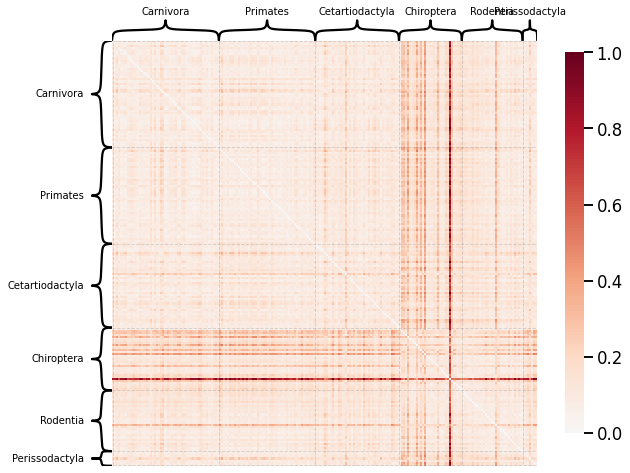

In [250]:
scaled_lap_dissim, eigs, ws = laplacian_dissim(graphs, transform=None, metric='cosine', smooth_eigvals=True, normalize=True)

#transformed = pass_to_ranks(scaled_lap_dissim, method='simple-all')
ax = heatmap(scaled_lap_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=10)
ax.figure.set_facecolor('w')

0.01685564001614115
area = 0.9970012499994536


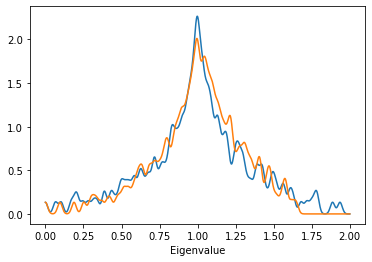

In [241]:
#lap = to_laplacian(graphs[0], 'I-DAD')
#lap = laplacian(graph, normed=True)

# find and sort eigenvalues
#w = np.linalg.eigvalsh(lap)
##if not np.all(np.real(w)):
    #print('Complex eigenvalues.')
xs = np.linspace(0, 2, 2000)
plt.figure(facecolor='w')
plt.plot(xs, eigs[0])
plt.plot(xs, eigs[5])
plt.xlabel('Eigenvalue')

print(cosine(eigs[0], eigs[5])) # cosine difference

area = np.trapz(eigs[5], dx=0.001)
print("area =", area) # area under the curve, should be 1

Text(0.5, 0, 'Eigenvalue')

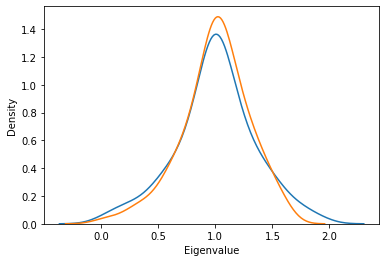

In [240]:
plt.figure(facecolor='w')
ax = sns.kdeplot(ws[0])
ax = sns.kdeplot(ws[5])
ax.set_xlabel('Eigenvalue')

In [226]:
values, counts = np.unique(np.array(labels), return_counts = True)
val_counts_dict = {}
for i, count in enumerate(counts):
    val_counts_dict[count] = values[i]

counts_sorted = np.flip(np.sort(counts))
#values_sorted = ['Chiroptera', 'Rodentia', 'Cetartiodactyla', 'Carnivora', 'Perissodactyla', 'Primates']

values_sorted = []
for count in counts_sorted:
    values_sorted.append(val_counts_dict[count])

labels_sorted = list(np.repeat(values_sorted, counts_sorted))

graphs_sorted = []
for i, label in enumerate(labels_sorted):
    idx = labels.index(label)
    labels[idx] = 0
    graphs_sorted.append(graphs[idx])

graphs_sorted = np.array(graphs_sorted)

print(np.shape(graphs_sorted))

(203, 200, 200)


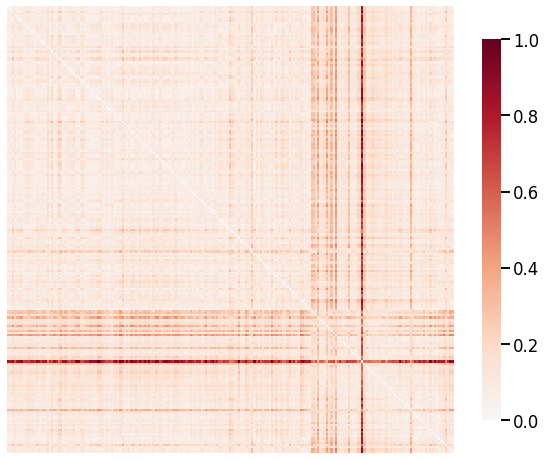

In [228]:
# confirm graphs are in correct order
scaled_lap_dissim, eigs, ws = laplacian_dissim(graphs_sorted, metric='cosine', smooth_eigvals=True, normalize=True)

ax = heatmap(scaled_lap_dissim, context="talk")
ax.figure.set_facecolor('w')

[51, 97, 137, 167, 196, 203]


[Text(0.5, 0, 'Carnivora'),
 Text(1.5, 0, 'Primates'),
 Text(2.5, 0, 'Cetartiodactyla'),
 Text(3.5, 0, 'Chiroptera'),
 Text(4.5, 0, 'Rodentia'),
 Text(5.5, 0, 'Perissodactyla')]

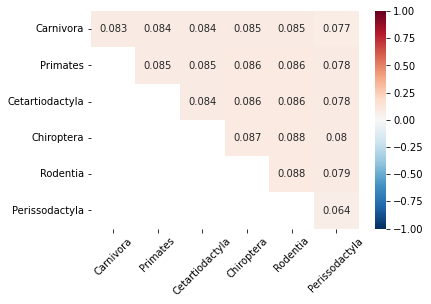

In [233]:
# calculate median spectral distance within order
counts_acc = list(np.cumsum(counts_sorted))
print(counts_acc)
dissim_median = np.zeros((6, 6))
for i, count1 in enumerate(counts_sorted):
    for j, count2 in enumerate(counts_sorted):
        subset = scaled_lap_dissim[:count1, :count2]
        dissim_median[i, j] = np.median(subset)

import seaborn as sns
import matplotlib.pyplot as plt
mask = np.tril(np.ones_like(dissim_median), -1)
plt.figure(facecolor='w')
ax = sns.heatmap(dissim_median, mask=mask, annot=True, vmin=-1, vmax=1, cmap='RdBu_r')
ax.set_yticklabels(values_sorted, rotation=0)
ax.set_xticklabels(values_sorted, rotation=45)